## Time series prediction

In [26]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from utils import MACD, RSI, Drawdown_current, volatility_rolling, extract, Close_price, log_return, WFCV, feature_engineering
import statsmodels.api as sm

In [27]:
returns_all = pd.read_csv('230216_returns.csv')

In [28]:
hu1_comdty = extract(returns_all, 'HG1 Comdty') # GC1  for gold, HG1 for copper, SI1 for silver
hu1_comdty["Close"] = Close_price(hu1_comdty)
hu1_comdty["log_return"] = log_return(hu1_comdty)

hu1_comdty.dropna(inplace=True)

hu1_comdty.head(), hu1_comdty.shape

(              return      Close  log_return
 Date                                       
 2000-01-05  0.010024  99.246813    0.009974
 2000-01-06 -0.004086  98.841251   -0.004095
 2000-01-07  0.001172  98.957126    0.001172
 2000-01-10 -0.008782  98.088065   -0.008821
 2000-01-11 -0.003544  97.740440   -0.003550,
 (5726, 3))

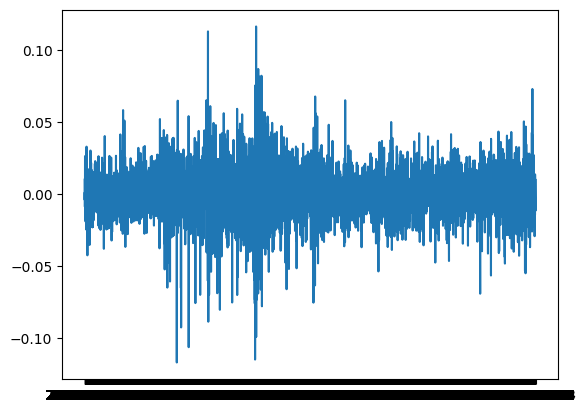

In [29]:
plt.plot(hu1_comdty.index, hu1_comdty['log_return'])

In [30]:
hu1_comdty["MACD"] = MACD(hu1_comdty)
hu1_comdty["RSI"] = RSI(hu1_comdty)
hu1_comdty["Drawdown"] = Drawdown_current(hu1_comdty)
hu1_comdty["Volatility_20"] = volatility_rolling(hu1_comdty, window=20)
hu1_comdty["Volatility_60"] = volatility_rolling(hu1_comdty, window=60)

lags = list(range(1, 11))
for lag in lags:
    hu1_comdty[f'lag_{lag}'] = hu1_comdty['log_return'].shift(lag)

In [31]:
X = hu1_comdty.dropna().drop(columns=['log_return', 'Close', 'return'])
y = hu1_comdty.dropna()['log_return']

rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

rf_pred, rf_truth, rf_mse, rf_r2 = WFCV(X, y, rf)

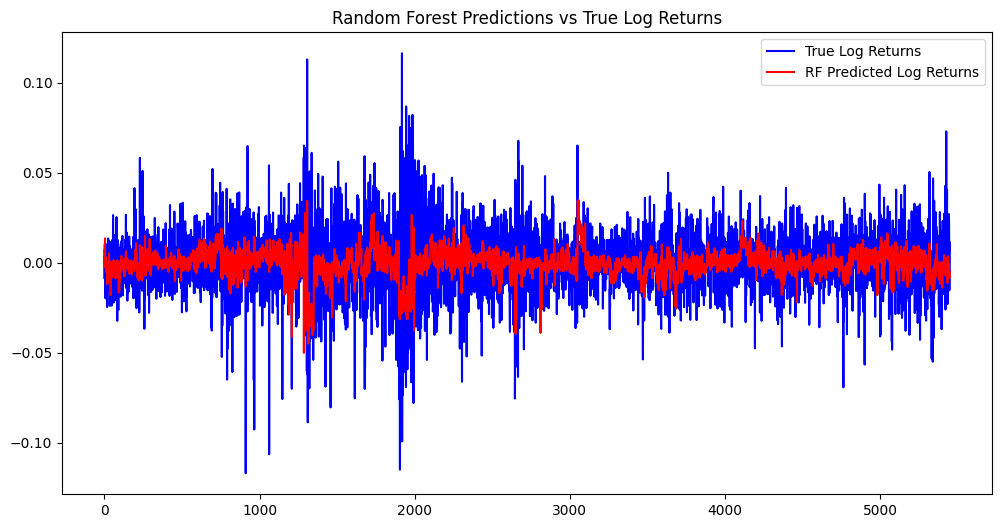

In [32]:
plt.figure(figsize=(12,6))
plt.plot(rf_truth, label='True Log Returns', color='blue')
plt.plot(rf_pred, label='RF Predicted Log Returns', color='red')
plt.legend()
plt.title('Random Forest Predictions vs True Log Returns')
plt.show()

In [33]:
reg = sm.OLS(rf_truth, sm.add_constant(rf_pred)).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     246.9
Date:                Mon, 02 Feb 2026   Prob (F-statistic):           1.89e-54
Time:                        12:14:22   Log-Likelihood:                 14516.
No. Observations:                5450   AIC:                        -2.903e+04
Df Residuals:                    5448   BIC:                        -2.901e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      2.143      0.0